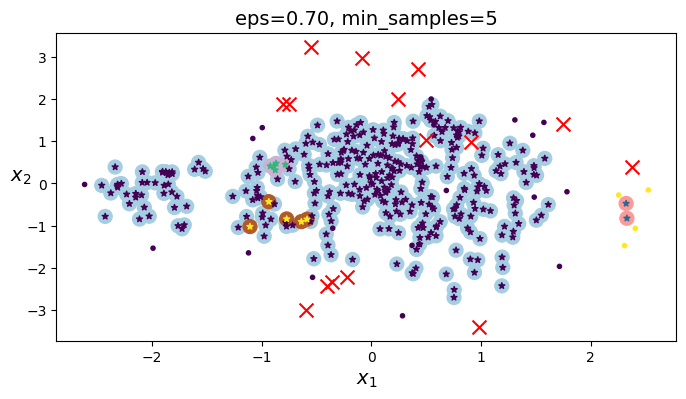

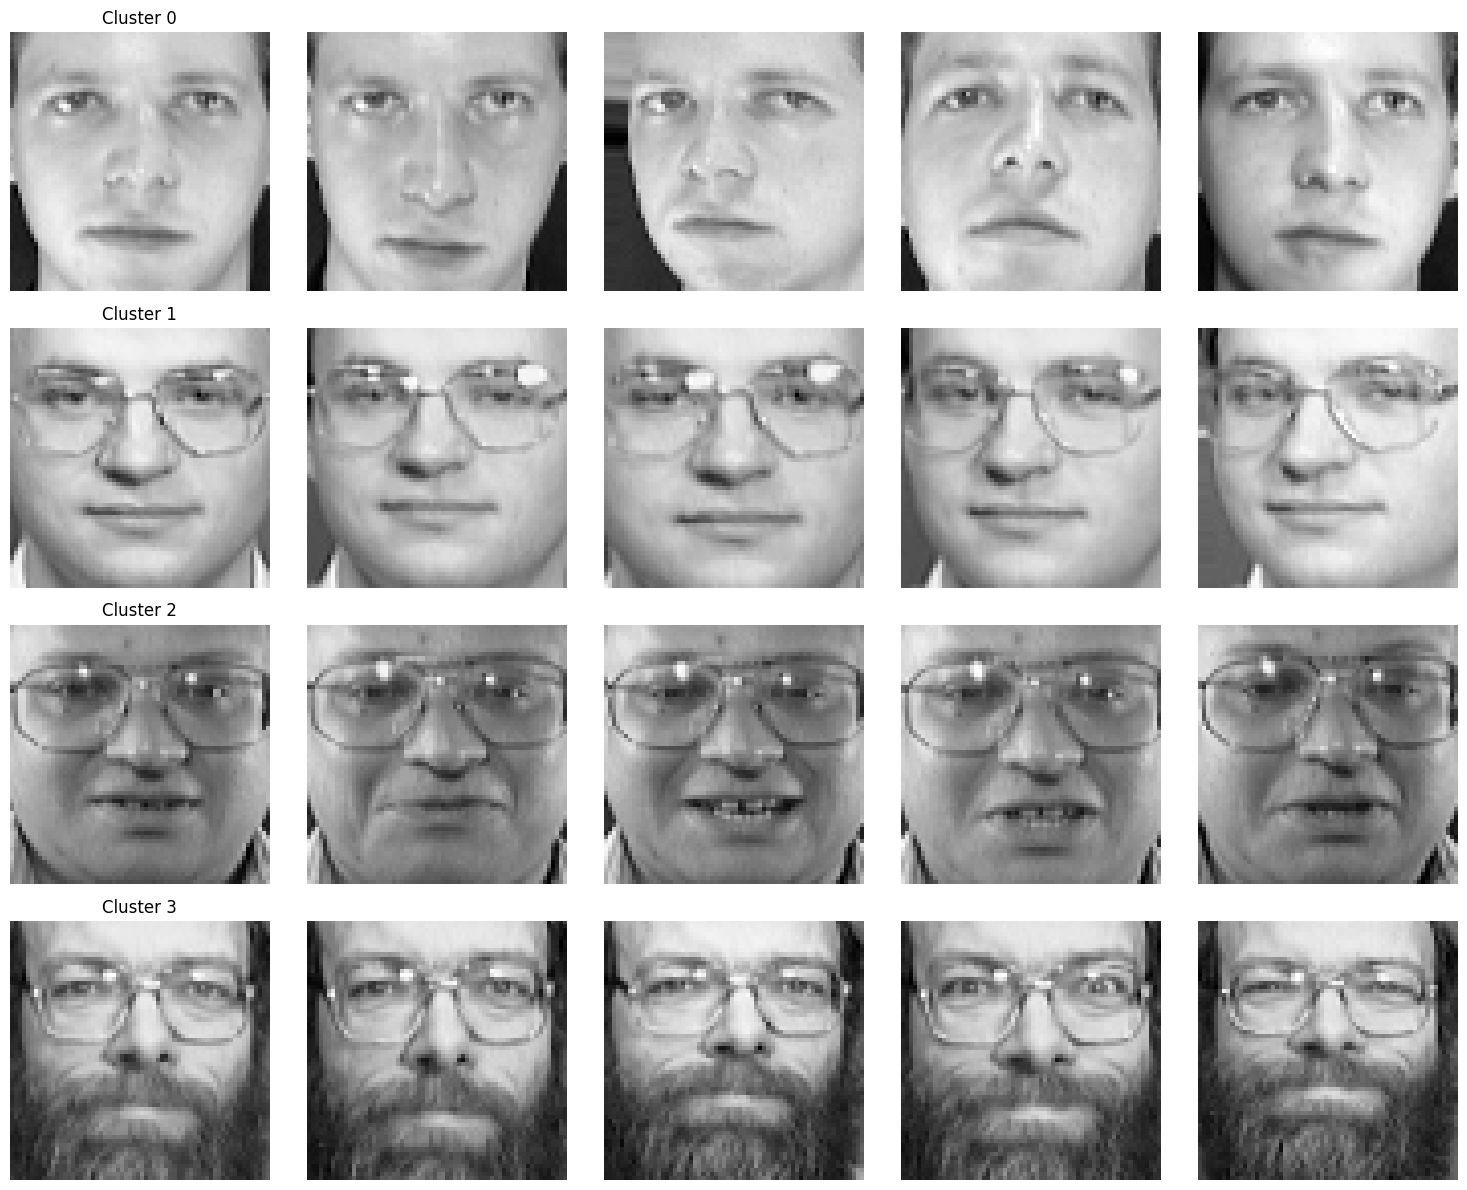

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

# Cargar el dataset Olivetti Faces
faces = fetch_olivetti_faces()
X = faces.data
y = faces.target

# Reducir dimensionalidad con PCA para visualización/clustering
pca = PCA(n_components=3, whiten=True, random_state=42)
X_pca = pca.fit_transform(X)

# Aplicar DBSCAN
dbscan = DBSCAN(eps=0.7, min_samples=5)
dbscan.fit(X_pca)

# Función para graficar
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = X[core_mask]
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]

    plt.scatter(cores[:, 0], cores[:, 1], c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1], c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

# Graficar resultados
plt.figure(figsize=(8, 4))
plot_dbscan(dbscan, X_pca, size=100)
plt.show()

# Mostrar algunas caras de cada cluster (versión corregida)
unique_labels = np.unique(dbscan.labels_)
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)

# Calcular el número necesario de filas para los subplots
n_samples_per_cluster = 5
n_cols = 5
n_rows = int(np.ceil(n_clusters * n_samples_per_cluster / n_cols))

plt.figure(figsize=(15, 3 * n_rows))
plot_index = 1  # Índice para posicionar los subplots

for i, label in enumerate(unique_labels):
    if label == -1:
        continue  # Saltar anomalías

    cluster_mask = (dbscan.labels_ == label)
    cluster_samples = X[cluster_mask][:n_samples_per_cluster]  # Mostrar primeras 5 caras del cluster

    for j, face in enumerate(cluster_samples):
        plt.subplot(n_rows, n_cols, plot_index)
        plt.imshow(face.reshape(64, 64), cmap='gray')
        plt.axis('off')
        if j == 0:
            plt.title(f"Cluster {label}")
        plot_index += 1

plt.tight_layout()
plt.show()

In [ ]:
labels = dbscan.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Ignora las anomalías
print(f"Clusters válidos: {n_clusters}")

Clusters válidos: 4


In [ ]:
print(faces.data.shape)
print(faces.target.shape)
print(np.unique(faces.target))

(400, 4096)
(400,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


In [ ]:
pca = PCA(n_components=2, whiten=True, random_state=42)
X_pca = pca.fit_transform(X)

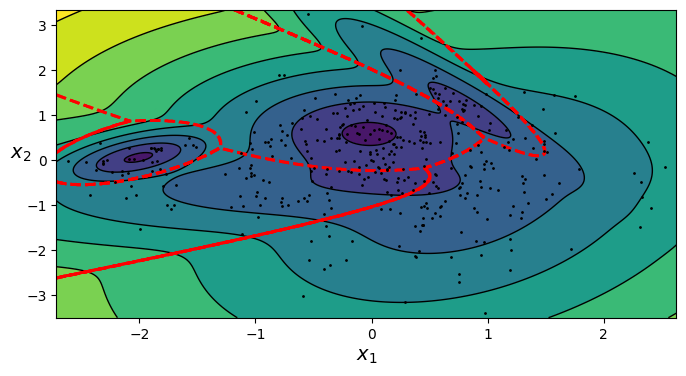

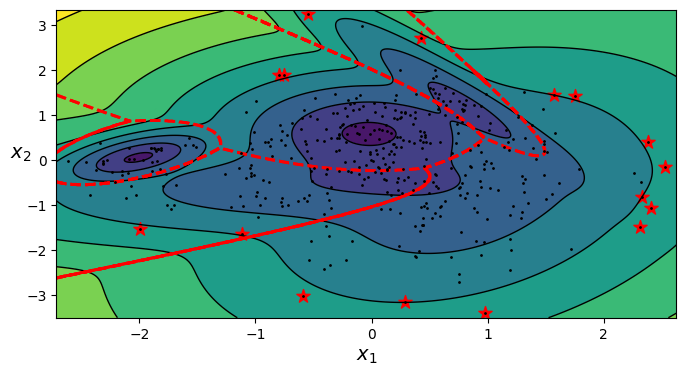

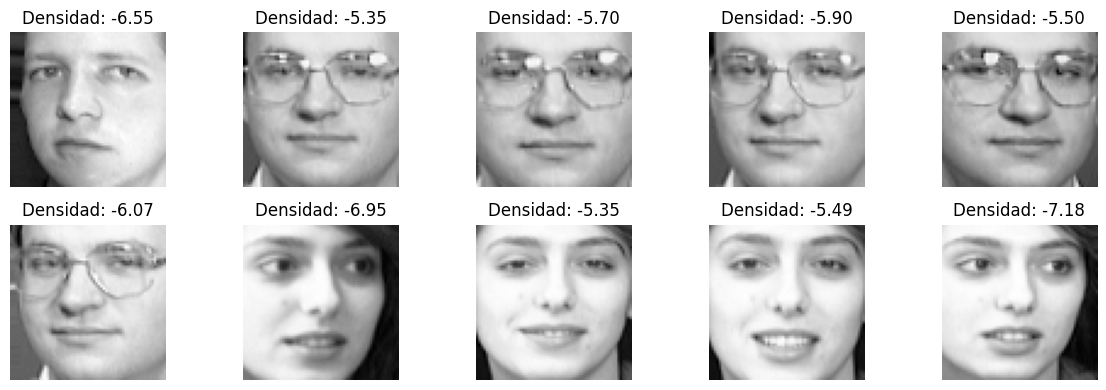

In [ ]:
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

# Aplicar Gaussian Mixture
gm = GaussianMixture(n_components=5, n_init=10, random_state=42)
gm.fit(X_pca)

# Función para graficar (similar a la del docente)
def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12),
                 linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                 linewidths=2, colors='r', linestyles='dashed')

    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

# Graficar resultados
plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, X_pca)
plt.show()

# Detección de anomalías
densities = gm.score_samples(X_pca)
density_threshold = np.percentile(densities, 4)  # Considerar el 4% como anomalías
anomalies = X_pca[densities < density_threshold]

plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, X_pca)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*', s=100)
plt.show()

# Mostrar las caras consideradas anomalías
plt.figure(figsize=(12, 4))
for i, anomaly_idx in enumerate(np.where(densities < density_threshold)[0][:10]):  # Mostrar primeras 10 anomalías
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[anomaly_idx].reshape(64, 64), cmap='gray')
    plt.axis('off')
    plt.title(f"Densidad: {densities[anomaly_idx]:.2f}")
plt.tight_layout()
plt.show()

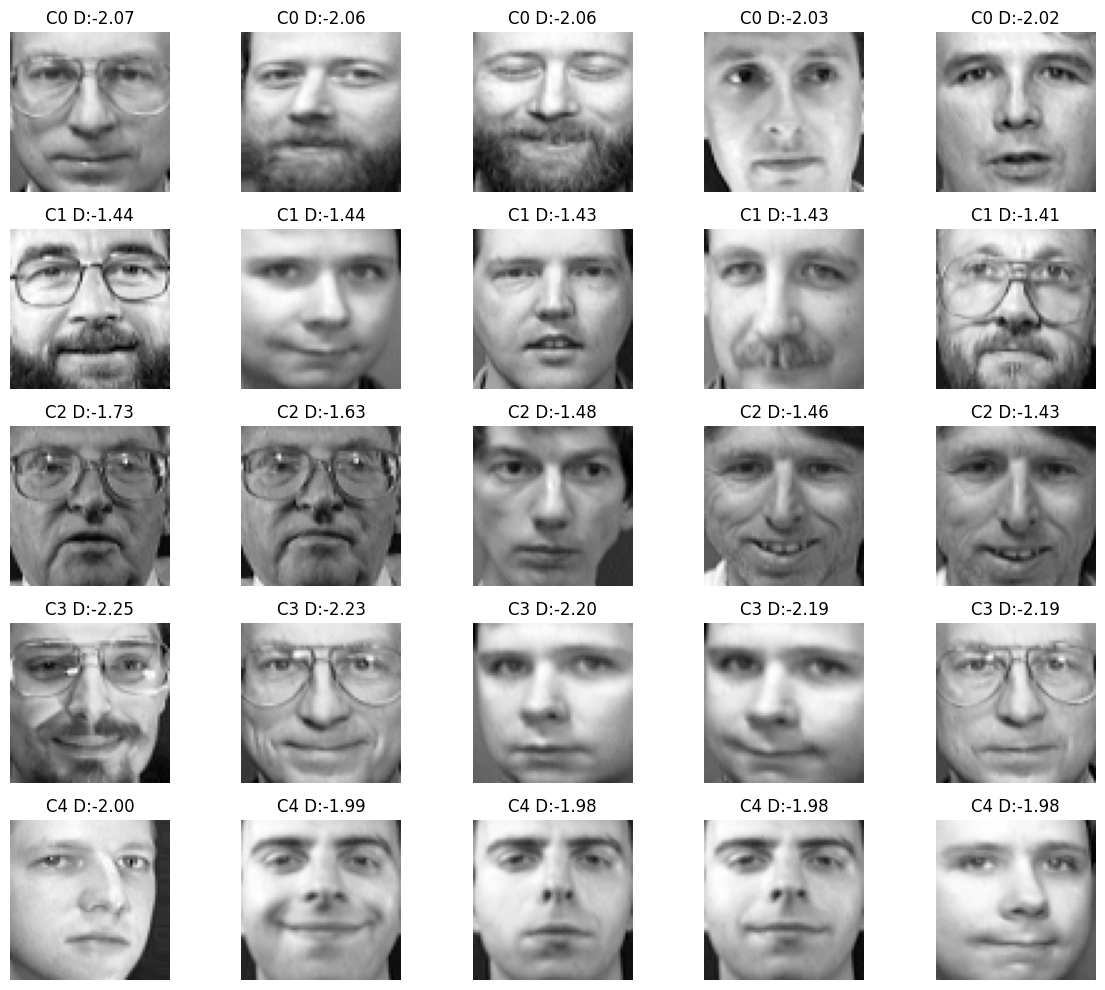

In [ ]:
# Para ver las 5 caras más representativas de cada cluster
plt.figure(figsize=(12, 10))
for cluster_id in range(5):  # Cambia según n_components
    cluster_indices = np.where(gm.predict(X_pca) == cluster_id)[0]
    cluster_densities = densities[cluster_indices]
    top_indices = cluster_indices[np.argsort(cluster_densities)[-5:]]  # 5 con mayor densidad

    for i, idx in enumerate(top_indices):
        plt.subplot(5, 5, cluster_id*5 + i + 1)
        plt.imshow(X[idx].reshape(64, 64), cmap='gray')
        plt.axis('off')
        plt.title(f"C{cluster_id} D:{densities[idx]:.2f}")
plt.tight_layout()
plt.show()


In [ ]:
pca = PCA(n_components=3, whiten=True, random_state=42)
X_pca = pca.fit_transform(X)

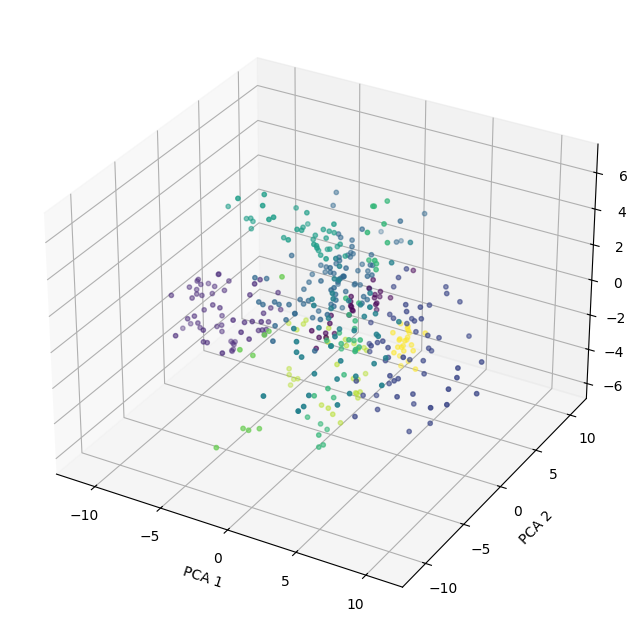

In [ ]:
from mpl_toolkits.mplot3d import Axes3D


def plot_gmm_3d(gm, X):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Graficar puntos
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=gm.predict(X), cmap='viridis', s=10)

    ax.set_xlabel('PCA 1')
    ax.set_ylabel('PCA 2')
    ax.set_zlabel('PCA 3')
    plt.show()

# Usar PCA con 3 componentes
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X)

# Ajustar GMM y graficar
gm_3d = GaussianMixture(n_components=10, random_state=42)
gm_3d.fit(X_pca_3d)
plot_gmm_3d(gm_3d, X_pca_3d)
